In [22]:
import numpy as np
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as img

def add_awgn_noise(image, variance):
    if len(image.shape) == 2:  # Grayscale image
        noise = np.random.normal(0, np.sqrt(variance), image.shape)
        noisy_image = image + noise
    else:  # Color image
        noisy_image = np.zeros_like(image)
        for i in range(3):  # Add noise to each channel independently
            noise = np.random.normal(0, np.sqrt(variance), image[:, :, i].shape)
            noisy_image[:, :, i] = image[:, :, i] + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)


In [31]:
def calculate_psnr(org_image, noisy__image):
    mse = np.mean((noisy__image - org_image)**2)
    if mse != 0 : 
        return (10 * np.log10((255 ** 2) / mse))

    else:
        return float('inf')

In [35]:

def calculate_ssim(org_image, noisy_image, C1 = 6.5025, C2 = 58.5225):
    org_image, noisy_image = org_image.astype(np.float64), noisy_image.astype(np.float64)
    mu1 = uniform_filter(org_image, 11)
    mu2 = uniform_filter(noisy_image, 11)

    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = uniform_filter(org_image * org_image, 11) - mu1_sq
    sigma2_sq = uniform_filter(noisy_image * noisy_image, 11) - mu2_sq
    sigma12 = uniform_filter(org_image * noisy_image, 11) - mu1_mu2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

from scipy.ndimage import gaussian_filter

def gaussian_blur(image, sigma):
    return gaussian_filter(image, sigma=sigma)


In [8]:
import pywt

def hard_thresholding(coeffs, threshold):
    return [pywt.threshold(c, threshold, mode='hard') for c in coeffs]

def soft_thresholding(coeffs, threshold):
    return [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

def chen_method(coeffs, neighbor_size=3):
    # This method implements the denoising technique proposed by Chen et al.
    # For simplicity, this is a basic placeholder implementation.
    # Detailed implementation should follow the specific algorithm steps described in the paper.
    denoised_coeffs = []
    for coeff in coeffs:
        denoised = np.copy(coeff)
        for i in range(neighbor_size, coeff.shape[0] - neighbor_size):
            for j in range(neighbor_size, coeff.shape[1] - neighbor_size):
                local_patch = coeff[i - neighbor_size:i + neighbor_size + 1, j - neighbor_size:j + neighbor_size + 1]
                threshold_value = np.median(np.abs(local_patch))
                if abs(coeff[i, j]) < threshold_value:
                    denoised[i, j] = 0
        denoised_coeffs.append(denoised)
    return denoised_coeffs


In [39]:
import matplotlib.pyplot as plt

def plot_psnr_ssim_vs_noise_variance(clean_image):
    noise_variances = np.linspace(0, 50, 10)
    psnr_values = []
    ssim_values = []
    
    for variance in noise_variances:
        noisy_image = add_awgn_noise(clean_image, variance)
        blurred_image = gaussian_blur(noisy_image, sigma=1)
        psnr = calculate_psnr(clean_image, blurred_image)
        ssim = calculate_ssim(clean_image, blurred_image)
        
        psnr_values.append(psnr)
        ssim_values.append(ssim)
    
    plt.figure(figsize=(8, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(noise_variances, psnr_values, marker='o')
    plt.title('PSNR vs. Noise Variance')
    plt.xlabel('Noise Variance')
    plt.ylabel('PSNR')
    
    plt.subplot(1, 2, 2)
    plt.plot(noise_variances, ssim_values, marker='o')
    plt.title('SSIM vs. Noise Variance')
    plt.xlabel('Noise Variance')
    plt.ylabel('SSIM')
    
    plt.tight_layout()
    plt.show()

def plot_psnr_ssim_vs_gaussian_variance(clean_image):
    gaussian_variances = np.linspace(0.5, 5, 10)
    psnr_values = []
    ssim_values = []
    
    for variance in gaussian_variances:
        blurred_image = gaussian_blur(clean_image, sigma=variance)
        psnr = calculate_psnr(clean_image, blurred_image)
        ssim = calculate_ssim(clean_image, blurred_image)
        
        psnr_values.append(psnr)
        ssim_values.append(ssim)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(gaussian_variances, psnr_values, marker='o')
    plt.title('PSNR vs. Gaussian Variance')
    plt.xlabel('Gaussian Variance')
    plt.ylabel('PSNR')
    
    plt.subplot(1, 2, 2)
    plt.plot(gaussian_variances, ssim_values, marker='o')
    plt.title('SSIM vs. Gaussian Variance')
    plt.xlabel('Gaussian Variance')
    plt.ylabel('SSIM')
    
    plt.tight_layout()
    plt.show()


In [10]:
def compare_methods_on_real_noisy_images(noisy_image, clean_image):
    assumed_variances = [10, 20, 30, 40, 50]
    psnr_values = []
    ssim_values = []
    
    for variance in assumed_variances:
        denoised_image = gaussian_blur(noisy_image, sigma=np.sqrt(variance))
        psnr = calculate_psnr(clean_image, denoised_image)
        ssim = calculate_ssim(clean_image, denoised_image)
        
        psnr_values.append(psnr)
        ssim_values.append(ssim)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(assumed_variances, psnr_values, marker='o')
    plt.title('PSNR vs. Assumed Noise Variance')
    plt.xlabel('Assumed Noise Variance')
    plt.ylabel('PSNR')
    
    plt.subplot(1, 2, 2)
    plt.plot(assumed_variances, ssim_values, marker='o')
    plt.title('SSIM vs. Assumed Noise Variance')
    plt.xlabel('Assumed Noise Variance')
    plt.ylabel('SSIM')
    
    plt.tight_layout()
    plt.show()


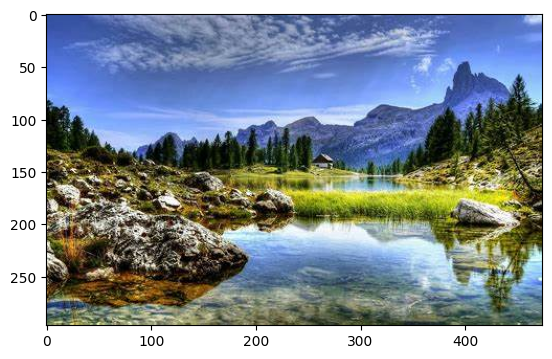

In [26]:
org_image = img.imread('OIP.jpg')
noisy_image = add_awgn_noise(org_image, 5)
plt.imshow(org_image)

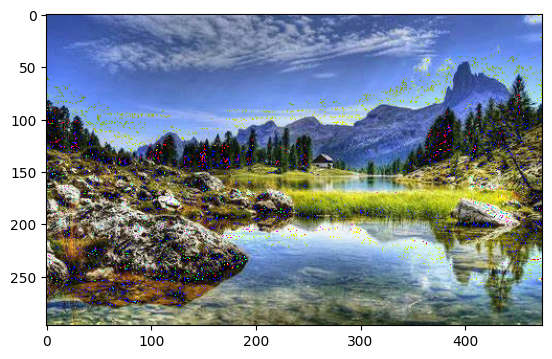

In [27]:
plt.imshow(noisy_image)

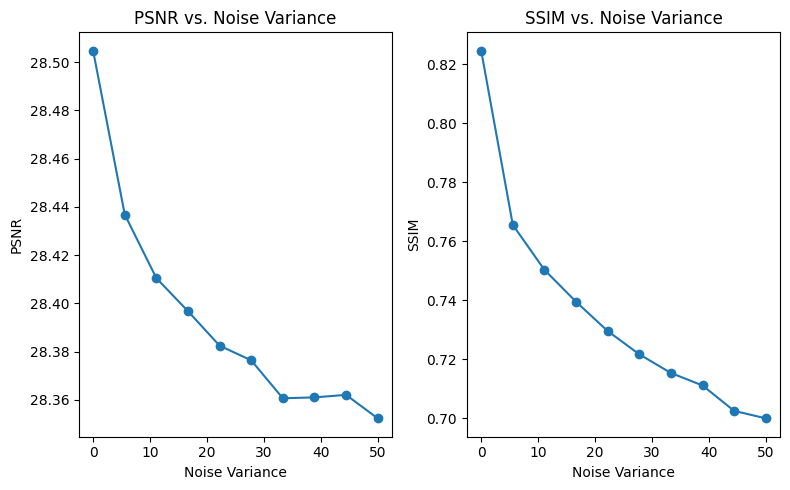

In [40]:
plot_psnr_ssim_vs_noise_variance(org_image)

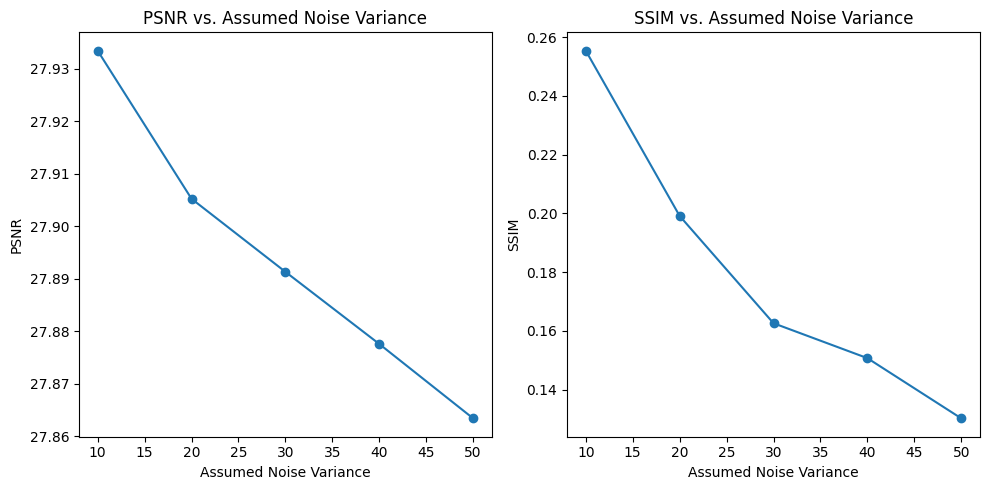

In [41]:
compare_methods_on_real_noisy_images(noisy_image, org_image)